<a href="https://colab.research.google.com/github/Ermi1223/conditional-diffusion-tutorial/blob/main/MNIST_Conditional_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST-Conditional-Diffusion-Model**

**Step 1: Setup GPU Acceleration**

In [ ]:
# First cell: Setup GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


**Step 2: Install Required Packages**

In [ ]:
# Cell 1: Install required packages
!pip install diffusers transformers accelerate matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Step 3: Import Libraries and Configuration**

In [2]:
# Cell 2: Import libraries and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel,DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import numpy as np

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 32
batch_size = 128
timesteps = 200
num_classes = 10  # Digits 0-9
embed_dim = 256
guidance_scale = 7.5
lr = 1e-4
epochs = 10

**Step 4: Dataset Preparation**

In [4]:
# Cell 3: MNIST Dataset preparation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Single channel
])

train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Text tokenizer for digit descriptions
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

**Step 5: Model Architecture**

In [5]:
from diffusers import UNet2DConditionModel
import torch.nn as nn
import torch
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ConditionalDiffusion(nn.Module):
    def __init__(self, num_classes=None, embed_dim=1280, guidance_scale=1.0):
        super().__init__()

        self.embed_dim = embed_dim
        self.guidance_scale = guidance_scale

        # ✅ Base U-Net with matching cross_attention_dim
        self.unet = UNet2DConditionModel(
            sample_size=image_size,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
            cross_attention_dim=embed_dim,  # must match conditioning dimension
        )

        # ✅ Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU()
        )

        # ✅ Class embedding (+1 for null class index)
        if num_classes is not None:
            self.class_emb = nn.Embedding(num_classes + 1, embed_dim)  # +1 ensures no index error
            self.null_label_idx = num_classes  # Null class index: e.g., 10 for MNIST
        else:
            self.class_emb = None
            self.null_label_idx = None

        # ✅ Text conditioning (optional, for future use)
        self.text_proj = nn.Linear(768, embed_dim)

    def forward(self, x, t, class_labels=None, text_emb=None):
        # Time embedding: [batch, embed_dim]
        t_emb = self.time_mlp(t)

        # Conditioning: initialize as zeros
        cond = torch.zeros_like(t_emb)

        # Class conditioning
        if class_labels is not None and self.class_emb is not None:
            cond += self.class_emb(class_labels)

        # Text conditioning (optional)
        if text_emb is not None:
            cond += self.text_proj(text_emb)

        # Classifier-free guidance scaling
        cond = self.guidance_scale * cond

        # Combine time + conditioning
        combined_emb = t_emb + cond  # [batch, embed_dim]
        combined_emb = combined_emb.unsqueeze(1)  # [batch, 1, embed_dim] → required by UNet2DConditionModel

        # Run through U-Net
        return self.unet(x, t, encoder_hidden_states=combined_emb).sample


# Example: Define model safely with fixed embedding
embed_dim = 1280  # Required: must match UNet cross_attention_dim
guidance_scale = 1.0
num_classes = 10  # For MNIST digits 0-9

model = ConditionalDiffusion(num_classes=num_classes, embed_dim=embed_dim, guidance_scale=guidance_scale).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


Model parameters: 20.40M


**Step 6:Diffusion Utilities**

In [6]:
# Cell 5: Diffusion utilities for MNIST
import math

# Cosine beta schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(timesteps).to(device)

# Pre-calculate diffusion parameters
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Forward diffusion (add noise to images)
def forward_diffusion(x0, t, noise):
    sqrt_alpha = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alpha * x0 + sqrt_one_minus * noise

In [7]:
def sample(model, class_label, timesteps=100, guidance_scale=1.0):
    model.eval()
    with torch.no_grad():
        # Start from pure noise
        x = torch.randn(1, 1, image_size, image_size, device=device)

        # Prepare timestep tensor
        for t in reversed(range(timesteps)):
            t_batch = torch.tensor([t], device=device, dtype=torch.long)

            # Prepare class label tensor
            class_label_tensor = torch.tensor([class_label], device=device, dtype=torch.long)

            # Predict noise
            pred_noise = model(x, t_batch, class_labels=class_label_tensor)

            # DDPM single-step update (simplified)
            beta = betas[t]
            alpha = alphas[t]
            alpha_hat = alphas_cumprod[t]
            sqrt_one_minus_alpha_hat = sqrt_one_minus_alphas_cumprod[t]
            sqrt_alpha_hat = sqrt_alphas_cumprod[t]

            coef1 = 1 / torch.sqrt(alpha)
            coef2 = (1 - alpha) / torch.sqrt(1 - alpha_hat)

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = coef1 * (x - coef2 * pred_noise) + torch.sqrt(beta) * noise

        return x, None


In [8]:
# Cell 6: Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = DDPMScheduler(
    num_train_timesteps=timesteps,
    beta_schedule="squaredcos_cap_v2"
)

def denormalize(images):
    """Convert from [-1, 1] to [0,1] for display"""
    return (images + 1) / 2

**Step7: Training Function**

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

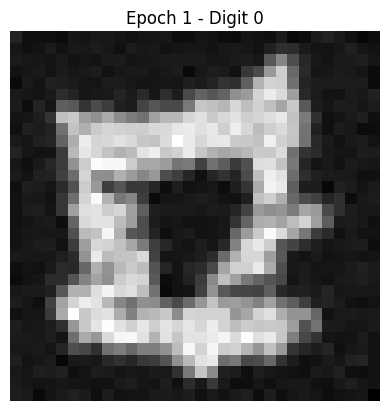

Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

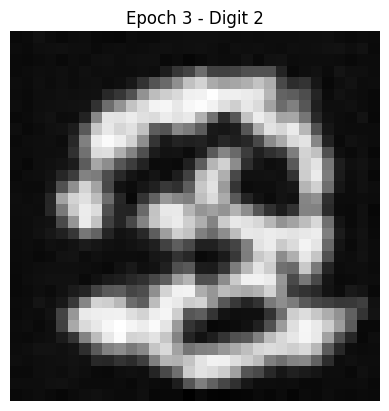

Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

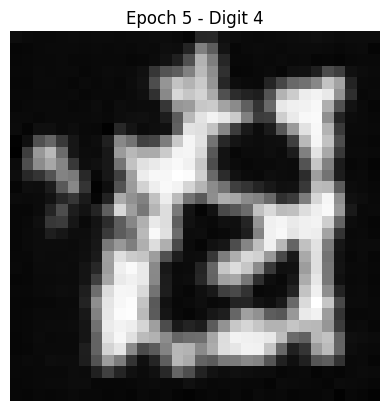

Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

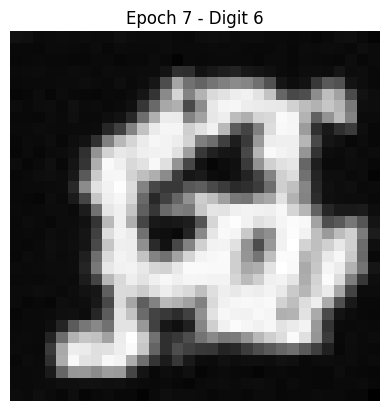

Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

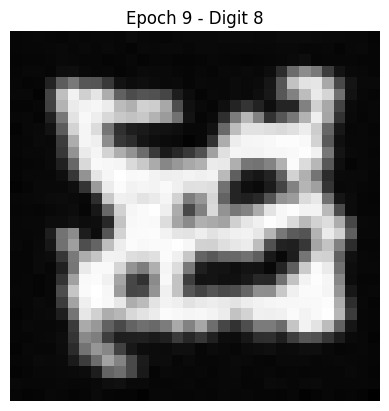

Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

In [9]:
# Define this globally based on your model's num_classes:
null_label_idx = num_classes  # e.g., if MNIST → 10 classes → index 10 = null

for epoch in range(epochs):
    model.train()
    progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

    for batch_idx, (images, labels) in progress:
        images = images.to(device)
        labels = labels.to(device)

        # Random timesteps
        t = torch.randint(0, timesteps, (images.shape[0],), device=device, dtype=torch.long)

        # Add noise
        noise = torch.randn_like(images)
        noisy_images = forward_diffusion(images, t, noise)

        # Classifier-free guidance: 15% chance of null conditioning
        use_null = torch.rand(images.shape[0], device=device) < 0.15
        cond_labels = labels.clone()
        cond_labels[use_null] = null_label_idx

        # Predict noise
        pred_noise = model(noisy_images, t, class_labels=cond_labels)

        # Compute loss
        loss = F.mse_loss(noise, pred_noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.set_postfix({"loss": f"{loss.item():.4f}"})

    # Save checkpoint every 3 epochs
    if (epoch + 1) % 3 == 0:
        torch.save(model.state_dict(), f"mnist_diffusion_epoch_{epoch+1}.pth")

    # Generate sample every 2 epochs
    if epoch % 2 == 0:
        with torch.no_grad():
            sample_img, _ = sample(model, class_label=epoch % num_classes)  # Only use valid classes here
            plt.imshow(sample_img[0, 0].cpu().numpy(), cmap="gray")
            plt.title(f"Epoch {epoch+1} - Digit {epoch % num_classes}")
            plt.axis("off")
            plt.show()


**Step 8: Sampling and Visualization Functions**

In [10]:
@torch.no_grad()
def sample(model, class_label=None, text_prompt=None, save_steps=True):
    model.eval()
    shape = (1, 1, image_size, image_size)  # 1 channel
    x = torch.randn(shape, device=device)
    steps = []

    # Prepare conditioning
    class_labels = torch.tensor([class_label], device=device) if class_label is not None else None

    if text_prompt:
        text_input = tokenizer(
            text_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        # Extract token embeddings
        text_emb = text_encoder(text_input.input_ids.to(device))[0]  # shape: [1, 77, 512]
        text_emb = text_emb[:, 0, :]  # Take CLS token -> shape: [1, 512]

        # Zero-pad to 768 to match the trained projection layer input
        pad = torch.zeros(text_emb.shape[0], 768 - 512, device=text_emb.device)  # shape: [1, 256]
        text_emb = torch.cat([text_emb, pad], dim=-1)  # shape: [1, 768]

    else:
        text_emb = None

    # Sampling loop
    for t in tqdm(range(timesteps-1, -1, -1), desc="Sampling"):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)

        # Predict noise
        pred_noise = model(x, t_batch, class_labels, text_emb)

        # Reverse diffusion step
        x = scheduler.step(pred_noise, t, x).prev_sample

        # Save intermediate steps
        if save_steps and t % 40 == 0:
            steps.append(denormalize(x.detach().cpu()))

    return denormalize(x.cpu()), steps

# Test sampling
sample_img, steps = sample(model, class_label=7)  # Digit 7


Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

**Step 9:Experiment Workflow**

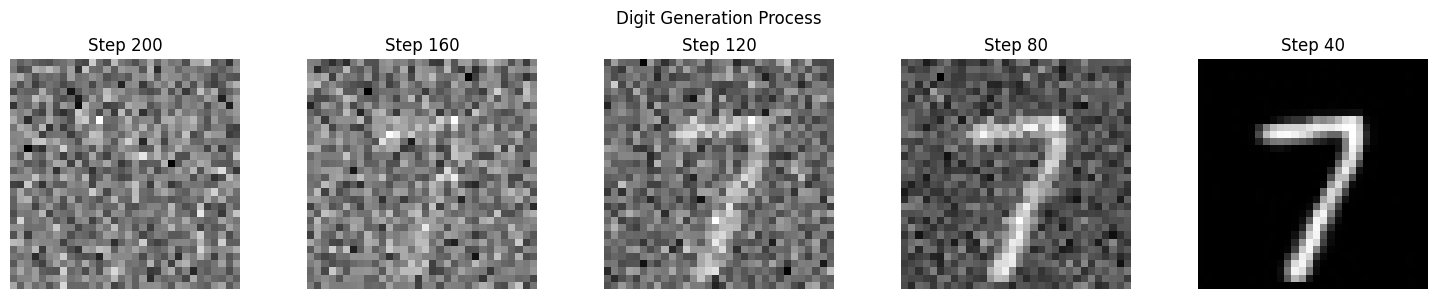

In [11]:
# Cell 9: Visualization functions for digits
def plot_steps(steps, title=""):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(steps):
        plt.subplot(1, len(steps), i+1)
        plt.imshow(img[0, 0], cmap="gray")
        plt.title(f"Step {timesteps - i*40}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_grid(images, titles, ncols=4):
    nrows = (len(images) + ncols - 1) // ncols
    plt.figure(figsize=(15, 3*nrows))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img[0, 0], cmap="gray")
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize denoising steps
plot_steps(steps, "Digit Generation Process")

**Step 10: Prompt engineering:**

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

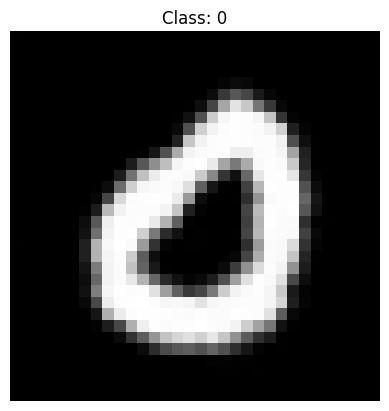

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

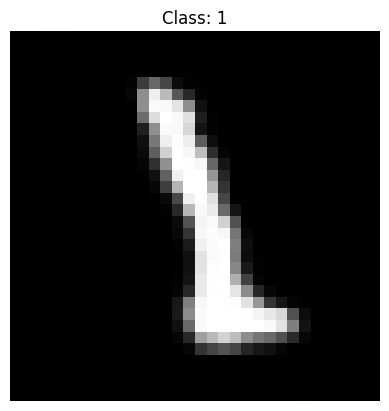

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

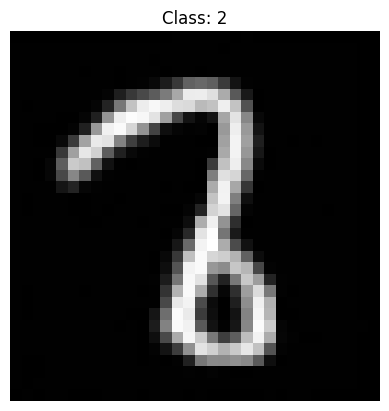

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

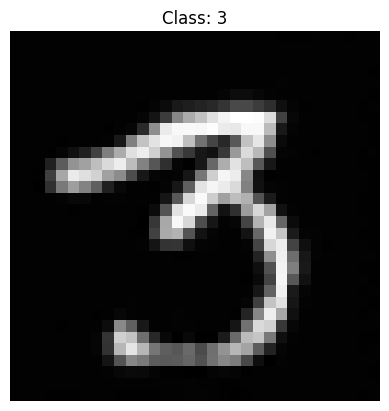

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

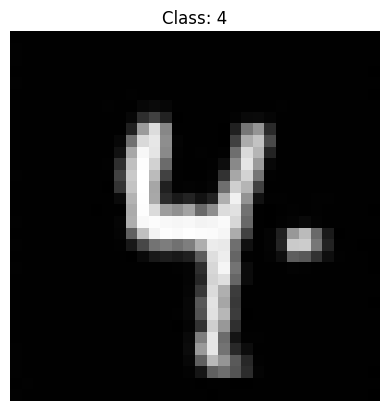

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

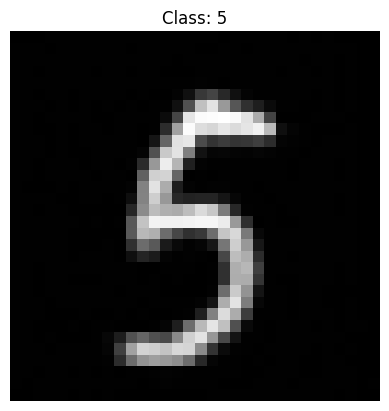

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

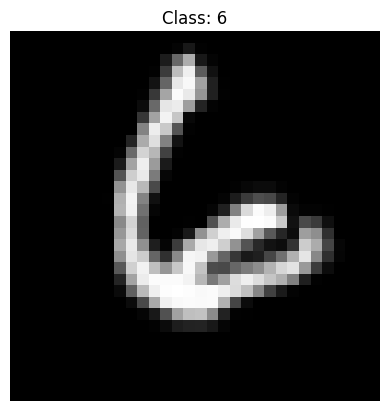

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

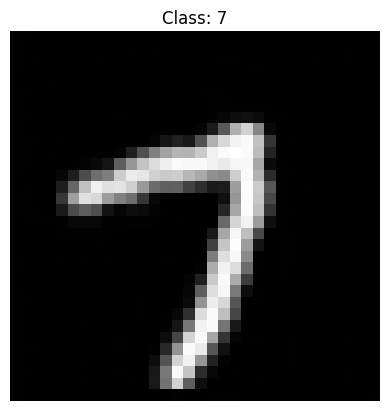

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

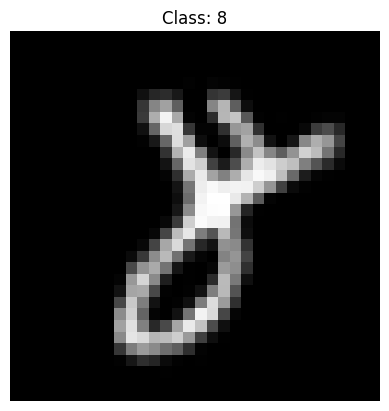

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

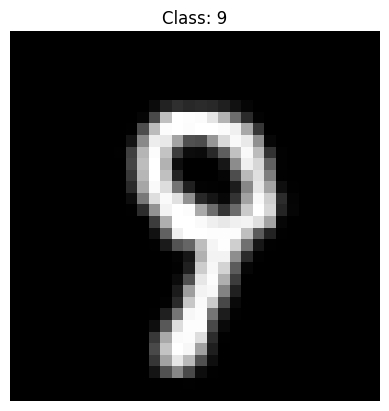

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

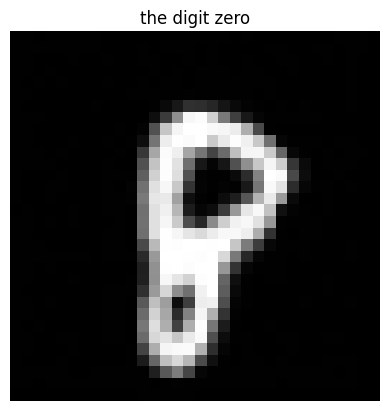

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

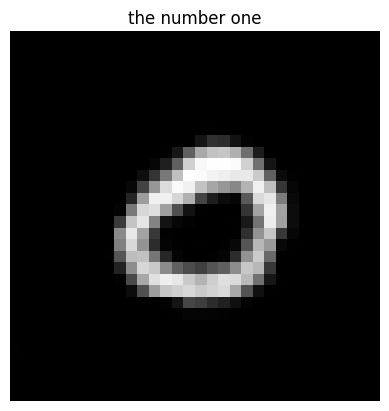

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

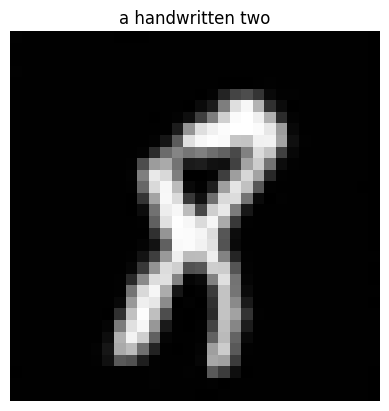

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

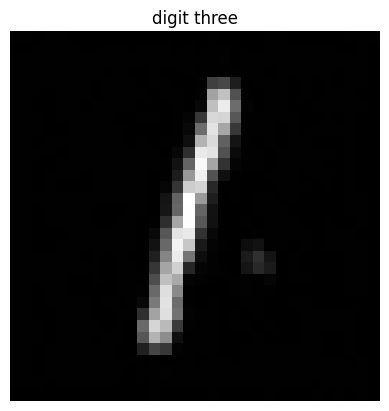

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

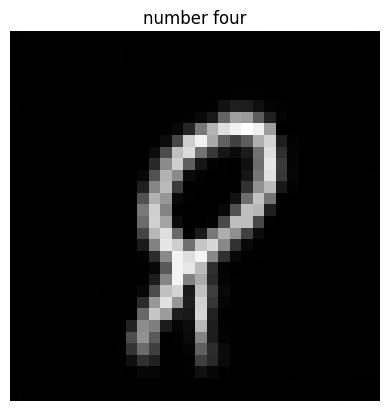

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

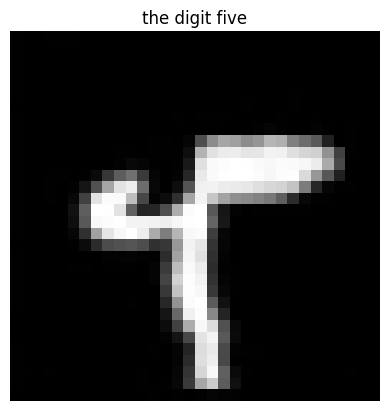

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

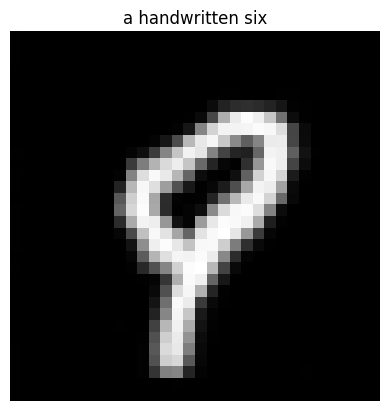

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

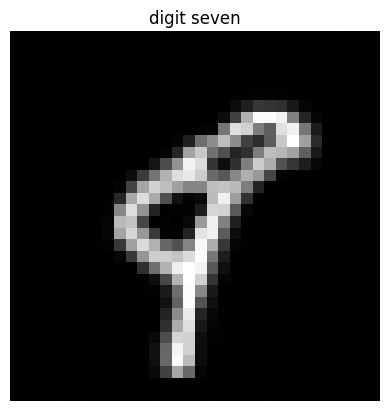

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

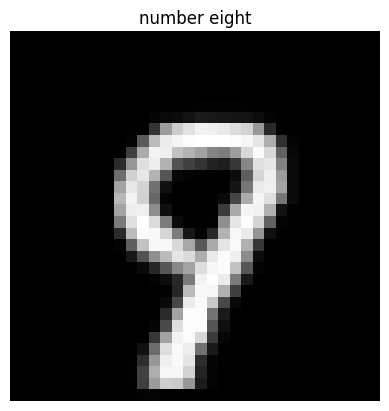

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

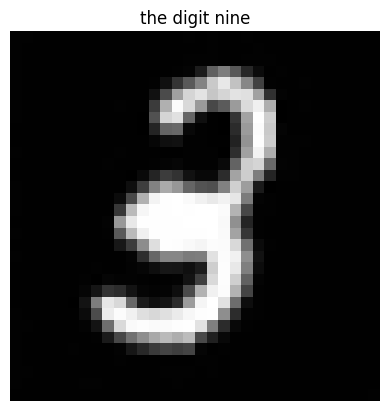

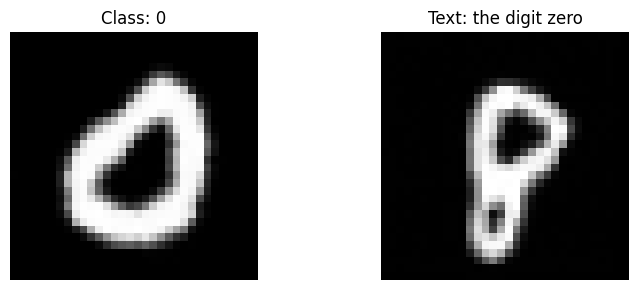

In [12]:
# Cell 10: Prompt engineering for digits
# Class label experiments
class_results = []
for digit in range(10):
    img, _ = sample(model, class_label=digit, save_steps=False)
    class_results.append(img)
    plt.imshow(img[0, 0], cmap="gray")
    plt.title(f"Class: {digit}")
    plt.axis("off")
    plt.show()

# Text prompt experiments
prompts = [
    "the digit zero",
    "the number one",
    "a handwritten two",
    "digit three",
    "number four",
    "the digit five",
    "a handwritten six",
    "digit seven",
    "number eight",
    "the digit nine"
]

text_results = []
for i, prompt in enumerate(prompts):
    img, _ = sample(model, text_prompt=prompt, save_steps=False)
    text_results.append(img)
    plt.imshow(img[0, 0], cmap="gray")
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# Compare class vs text conditioning
combined = [class_results[0], text_results[0]]
plot_grid(combined, ["Class: 0", "Text: the digit zero"])